<a href="https://colab.research.google.com/github/drewamorbordelon/drewamorbordelon.github.io/blob/master/Build_w2_CPI_Modeling_monthly_classification_asset_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
%matplotlib inline
import sys

!pip install category_encoders==2.*

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [83]:
df = pd.read_csv('/content/monthly economic data.csv', parse_dates=['date'], index_col='date')

In [84]:
df.tail()

,ism_pmi,head_CPI,head_CPI_roc,head_CPI_bps,core_CPI,core_CPIyoy,CRB,10yr_rate,10yr_roc,per_chg_yoy,swiss10yr,swiss_roc,dxy,dxy_roc,ind_pro_man,wti,wti_roc_qoq,wti_yoy,ba_credit_spread,copper_fut,copper_chg_yoy,gold,gold_roc_qoq,gold_chg_yoy,copper/gold,silver,gold/silver,pmi,roc_pmi,rocpmi_bps,fed rate
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01,41.5,255.902,0.376163,-114.216724,265.601,1.43831,117.20,0.64,-57.615894,-1.87,-0.487,-30.229226,99.57,2.238423,84.5913,16.55,-71.227399,-74.08393,1.697143,2.3055,-21.44009,1685.05,5.964659,33.58363,0.001368,14.973,112.539237,100.8026,-5.172839,-496.864463,0.05
2020-05-01,43.1,255.768,0.235532,-14.063049,265.441,1.23647,132.24,0.65,-42.477876,-1.49,-0.471,-43.389423,98.34,0.214002,87.8986,28.56,-43.490305,-53.04948,1.454000,2.4255,-12.92939,1728.30,9.032067,33.15201,0.001403,18.499,93.426672,84.5913,-19.722568,-1454.972961,0.05
2020-06-01,52.6,257.214,0.709470,47.393775,266.065,1.19426,137.97,0.66,-5.714286,-1.34,-0.439,19.293478,97.39,-1.675921,94.6167,38.31,31.153714,-29.91218,1.201818,2.7135,-2.16975,1780.67,13.323914,25.29720,0.001524,18.064,98.575620,87.8986,-16.685845,303.672364,0.08
2020-07-01,54.2,258.723,1.029338,31.986791,267.715,1.56609,143.69,0.55,-14.062500,-1.47,-0.529,8.624230,93.35,-6.246862,98.3754,40.71,145.981873,-29.01482,1.173182,2.8680,7.25890,1974.69,17.188807,38.03782,0.001452,24.216,81.544846,94.6167,-10.821074,586.477053,0.09
2020-08-01,56.0,259.681,1.321529,29.219150,268.747,1.72875,153.21,0.72,10.769231,-0.78,-0.410,-12.951168,92.14,-6.304657,99.3189,42.34,48.249300,-22.75132,1.024286,3.0410,13.99353,1968.03,13.870856,28.12224,0.001545,28.594,68.826677,98.3754,-6.918340,390.273402,0.10


In [85]:
def wrangle(df):

  df = df.copy()
 
  # New Feature `Copper/Gold Ratio`, `Copper/WTI` Ratio
  df['Copper/WTI Ratio'] = df['copper_fut'] / df['wti']
  df['Copper/CRB Ratio'] = df['copper_fut'] / df['CRB']

  # New Feature using rolling correlation
  df['CD quarter corr'] = df['copper_fut'].rolling(4).corr(df['dxy'])
  df['CG quarter gold corr'] = df['copper_fut'].rolling(4).corr(df['gold'])
  df['CC quarter gold corr'] = df['copper_fut'].rolling(4).corr(df['CRB'])
  
  # New Features using rolling correlation
  df['DG quarter corr'] = df['dxy'].rolling(4).corr(df['gold'])
  df['DCRB quarter corr'] = df['dxy'].rolling(4).corr(df['CRB']) 


  result = [] 
  for value in df['head_CPI_bps']: 
    if value >= 0.00: 
      result.append("Accelerate")  
    else:
      result.append("Decelerate")

  df['CPI overall'] = result




  # Play
  result_wti_roc_up=[]
  for value in df['wti_roc_qoq']:
    if value >= 0.00:
      result_wti_roc_up.append('+')
    else:
      result_wti_roc_up.append('-')

  df['wti_roc_up'] = result_wti_roc_up

  result_wti_yoy=[]
  for value in df['wti_yoy']:
    if value >= 0.00:
      result_wti_yoy.append('+')
    else:
      result_wti_yoy.append('-')

  df['wti_yoy_up'] = result_wti_yoy

  result_gold_roc_up=[]
  for value in df['gold_roc_qoq']:
    if value >= 0.00:
      result_gold_roc_up.append('-')
    else:
      result_gold_roc_up.append('+')

  df['gold_roc_up'] = result_gold_roc_up

  result_gold_yoy=[]
  for value in df['gold_chg_yoy']:
    if value >= 0.00:
      result_gold_yoy.append('-')
    else:
      result_gold_yoy.append('+')

  df['gold_yoy_up'] = result_gold_yoy


  df = df.drop(['head_CPI_roc', 'head_CPI_bps', 'head_CPI', 'core_CPI', 
                'core_CPIyoy', 'pmi', 'rocpmi_bps', 'roc_pmi', 'wti_yoy_up', 'gold_yoy_up'],axis=1)                          
                # , 'ism_pmi', 'pmi', 'rocpmi_bps', 'roc_pmi, , 'ism_pmi', , 'Copper/CRB Ratio', 'gold', , 'gold_roc_qoq', 'wti_roc_qoq'
              
                
            
  df = df.dropna()
  return df


In [86]:
df = wrangle(df)

In [87]:
# More FEATURES rolling mean and shifting for time series correlation
df['MA12_ISM'] = df['ism_pmi'].rolling(window=12).mean().shift(-20)
df['MA12_WTI'] = df['wti'].rolling(window=12).mean().shift(-20)
df['inverse_ba'] = df['ba_credit_spread'] * -1
df['MA12_inverse_ba'] = df['inverse_ba'].rolling(window=12).mean().shift(-20)

In [88]:
df.columns.value_counts()

CD quarter corr         1
copper_fut              1
wti_yoy                 1
MA12_inverse_ba         1
inverse_ba              1
copper_chg_yoy          1
CPI overall             1
ind_pro_man             1
dxy_roc                 1
fed rate                1
gold_chg_yoy            1
gold_roc_qoq            1
gold                    1
silver                  1
Copper/WTI Ratio        1
ba_credit_spread        1
10yr_roc                1
copper/gold             1
10yr_rate               1
Copper/CRB Ratio        1
CG quarter gold corr    1
swiss10yr               1
MA12_WTI                1
gold/silver             1
CRB                     1
MA12_ISM                1
DCRB quarter corr       1
dxy                     1
ism_pmi                 1
swiss_roc               1
wti                     1
wti_roc_qoq             1
gold_roc_up             1
per_chg_yoy             1
DG quarter corr         1
wti_roc_up              1
CC quarter gold corr    1
dtype: int64

In [89]:
df.columns

Index(['ism_pmi', 'CRB', '10yr_rate', '10yr_roc', 'per_chg_yoy', 'swiss10yr',
       'swiss_roc', 'dxy', 'dxy_roc', 'ind_pro_man', 'wti', 'wti_roc_qoq',
       'wti_yoy', 'ba_credit_spread', 'copper_fut', 'copper_chg_yoy', 'gold',
       'gold_roc_qoq', 'gold_chg_yoy', 'copper/gold', 'silver', 'gold/silver',
       'fed rate', 'Copper/WTI Ratio', 'Copper/CRB Ratio', 'CD quarter corr',
       'CG quarter gold corr', 'CC quarter gold corr', 'DG quarter corr',
       'DCRB quarter corr', 'CPI overall', 'wti_roc_up', 'gold_roc_up',
       'MA12_ISM', 'MA12_WTI', 'inverse_ba', 'MA12_inverse_ba'],
      dtype='object')

In [90]:
df.head(1)

,ism_pmi,CRB,10yr_rate,10yr_roc,per_chg_yoy,swiss10yr,swiss_roc,dxy,dxy_roc,ind_pro_man,wti,wti_roc_qoq,wti_yoy,ba_credit_spread,copper_fut,copper_chg_yoy,gold,gold_roc_qoq,gold_chg_yoy,copper/gold,silver,gold/silver,fed rate,Copper/WTI Ratio,Copper/CRB Ratio,CD quarter corr,CG quarter gold corr,CC quarter gold corr,DG quarter corr,DCRB quarter corr,CPI overall,wti_roc_up,gold_roc_up,MA12_ISM,MA12_WTI,inverse_ba,MA12_inverse_ba
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1994-05-01,58.2,130.67,7.17,16.585366,1.01,4.823728,11.192487,92.52,-2.147012,67.0655,17.88,20.97429,-10.33099,0.63381,1.04,19.18182,386.85,1.402359,1.37795,0.002688,5.53,69.954792,4.01,0.058166,0.007959,-0.541126,0.068039,0.997602,0.065925,-0.590234,Decelerate,+,-,48.458333,18.501667,-0.63381,-0.615206


In [91]:
# Cleaning column names for feature importance readability 
df.columns = ['ISM_PMI', 'Commodity_Index', '10yr_Rate','10yr_ROC', '10yr_yoy_Per_Chg', 
              'Swiss_10yr', 'Swiss_10yr_ROC', 'Dollar_Index', 'Dollar_ROC',
              'Indust_Prod_Manufacturing', 'WTI', 'WTI_ROC', 'WTI_yoy_Chg', 
              'Aaa/Baa_Yield_Spread', 'Copper', 'Copper_yoy_Chg', 'Gold', 
              'Gold_ROC', 'Gold_yoy_Chg', 'Copper/Gold', 'Silver', 
              'Gold/Silver', 'Fed_Funds_Rate', 'Copper/WTI', 'Copper/CRB', 
              'Copper/$_Quarter_Corr', 'Copper/Gold_Quarter_Corr', 
              'Copper/CRB_Quarter_Corr', '$/Gold_Quarter_Corr', 
              '$/CRB_Quarter_Corr', 'CPI_Direction', 'WTI_ROC_+', 'Gold_ROC_+',
              'MA_12_ISM', 'MA_12_WTI', 'Aaa/Baa_Spread_Inv', 'MA_12_Aaa/Baa_Spread_Inv']

In [92]:
# target is the `CPI overall`
# categorical
target = 'CPI_Direction'

y = df[target]
X = df.drop(target , axis=1)

In [93]:
cutoff1 = '2017-07-01'
mask1 = (df.index <= cutoff1)
train = df[mask1]
val = df[~mask1]

In [94]:
y_train = train[target]
X_train = train.drop([target], axis=1)

y_val = val[target]
X_val = val.drop(target, axis=1)

In [95]:
val.shape

(37, 37)

In [96]:
df.shape

(316, 37)

In [135]:
y_val.value_counts()

Accelerate    20
Decelerate    17
Name: CPI_Direction, dtype: int64

In [97]:
assert df.shape[0] == train.shape[0] + val.shape[0]

In [98]:
# Baseline --> Classification
from sklearn.metrics import mean_absolute_error
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5197132616487455


In [99]:
# Model 1: Logistic Regression

model = make_pipeline(
    OrdinalEncoder(),   
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression()    
)

model.fit(X_train, y_train);

In [100]:
print('Training Accuracy LOGR:', model.score(X_train, y_train))
print('Validtaion Accuracy LOGR:', model.score(X_val, y_val))
# print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
# print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))

Training Accuracy LOGR: 0.6989247311827957
Validtaion Accuracy LOGR: 0.5945945945945946


In [101]:
import numpy as np
coefficients = np.round(model.named_steps['logisticregression'].coef_, 3)
list(zip(X_train.columns, coefficients))

[('ISM_PMI',
  array([ 0.53 , -0.074,  0.761, -0.417, -0.864,  0.671,  0.067,  0.237,
          0.106,  0.242,  0.63 , -0.098, -0.736,  0.256, -0.32 ,  0.52 ,
          1.094, -0.153, -0.495,  0.219, -0.295,  0.426,  0.381, -0.342,
          0.305,  0.106,  0.062,  0.037, -0.065,  0.129, -0.018, -0.08 ,
          0.044,  0.166, -0.256,  0.074]))]

In [102]:
# Model 2: Random Forest Classifier
model_f = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(n_jobs=-1, n_estimators=20, random_state=42)
)

model_f.fit(X_train, y_train);

In [103]:
print('Train Accuracy (RF):', model_f.score(X_train, y_train))
print('Validation Accuracy (RF):', model_f.score(X_val, y_val))

Train Accuracy (RF): 0.992831541218638
Validation Accuracy (RF): 0.7027027027027027


In [104]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor

In [105]:
# Model 3: Gradient Boosting Classifier

model_grad = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    GradientBoostingClassifier(n_estimators=32)
)
model_grad.fit(X_train,y_train);

In [106]:

print('Train Accuracy:', model_grad.score(X_train, y_train))
print('Validation Accuracy:', model_grad.score(X_val, y_val))

Train Accuracy: 0.9354838709677419
Validation Accuracy: 0.7297297297297297


Confusion Matrix

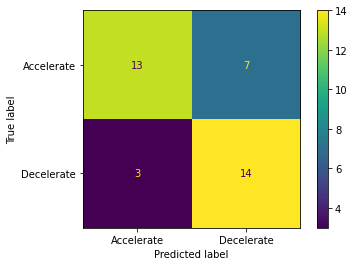

In [107]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(model_grad,
                      X_val, 
                      y_val,
                      display_labels=['Accelerate', 'Decelerate'],
                      values_format='.0f')

In [108]:
# True Neg = 14
# True Pos = 13
# False Pos = 7
# False Neg= 3

In [109]:
print(classification_report(y_val,model_grad.predict(X_val), target_names=['Accelerate','Decelerate']))

              precision    recall  f1-score   support

  Accelerate       0.81      0.65      0.72        20
  Decelerate       0.67      0.82      0.74        17

    accuracy                           0.73        37
   macro avg       0.74      0.74      0.73        37
weighted avg       0.75      0.73      0.73        37



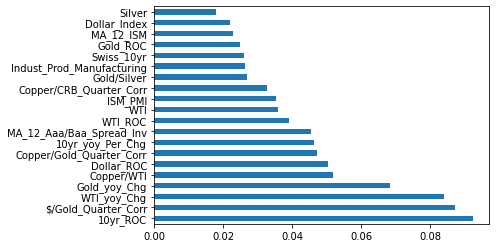

In [110]:
feature_imp = model_grad.named_steps['gradientboostingclassifier'] .feature_importances_
features = X_train.columns

pd.Series(feature_imp, features).sort_values(ascending=False).head(20).plot(kind='barh');

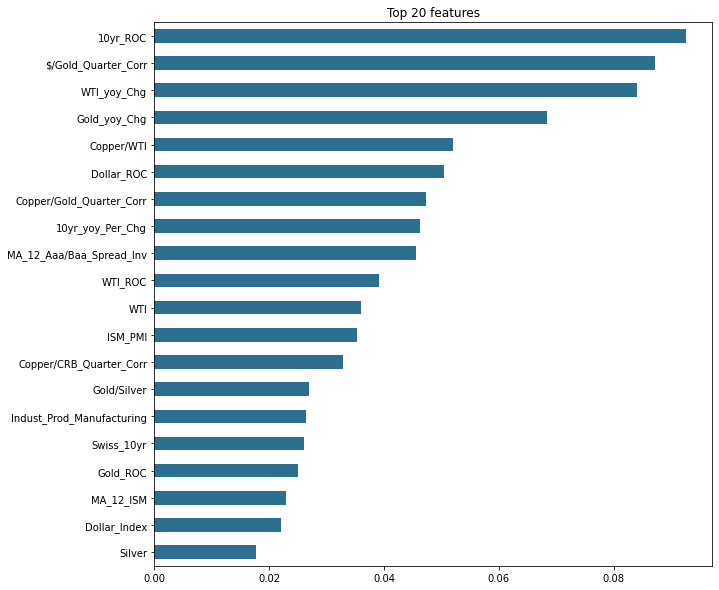

In [140]:
gbc = model_grad.named_steps['gradientboostingclassifier']
importances = pd.Series(gbc.feature_importances_, X_train.columns)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='#2D6F8E');

#PDP Plot

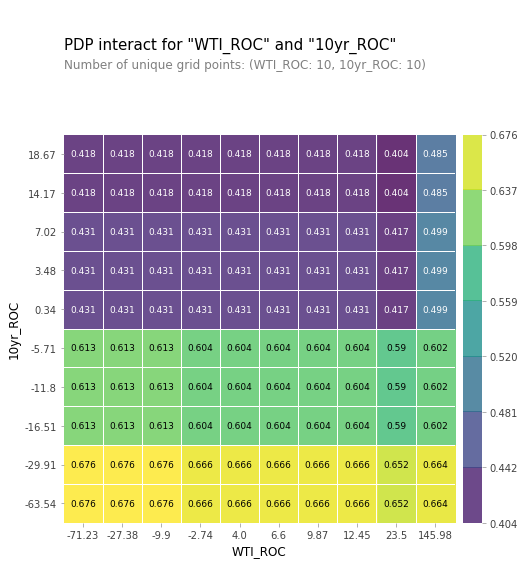

In [138]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot

features = ['WTI_ROC', '10yr_ROC']
interaction = pdp_interact(
    model=model_grad,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

While the rate of change in the price of WTI is highly negative the 10 year rate of change seems to have a higher effect on inflation accerlating as the 10 year rate of change increases. Futhermore, if the 10 year RoC remains elevated and the WTI RoC increaeses to the 23.5 level there is a shift to WTI RoC having a greater effect on inflation. Diving deeper into these thresholds could be an area for deeper investigation.

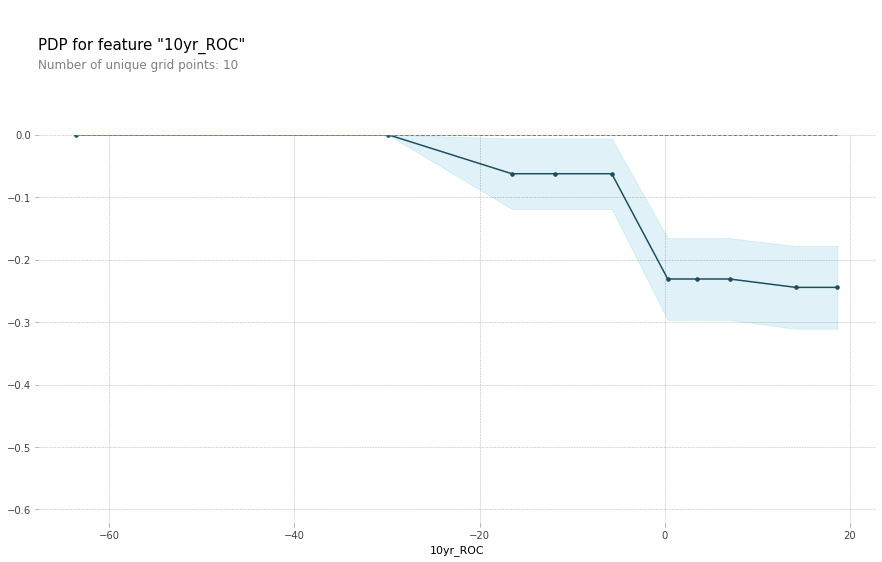

In [130]:
hnnmmmmnplt.rcParams['figure.dpi'] = 72


feature = '10yr_ROC'
isolated = pdp_isolate(
    model=model_grad,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

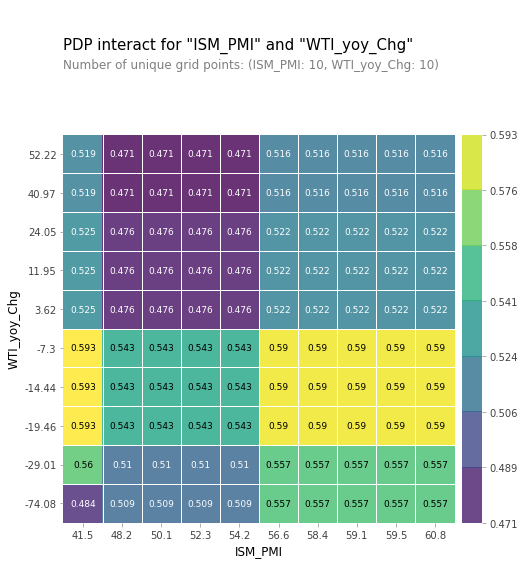

In [139]:
features = ['ISM_PMI', 'WTI_yoy_Chg']

interaction = pdp_interact(
    model=model_grad,
    dataset=X_val,
    model_features=X_train.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [114]:
# Model 4: XGB Regressor

model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    # SelectKBest(k=20),
    XGBClassifier(n_jobs=-1, n_estimators=23)
)

model_xgb.fit(X_train, y_train);

In [115]:
print('Train Accuracy:', model_xgb.score(X_train, y_train))
print('Validation Accuracy:', model_xgb.score(X_val, y_val)) 

Train Accuracy: 0.8960573476702509
Validation Accuracy: 0.7027027027027027


Confusion Matric XGB Regression

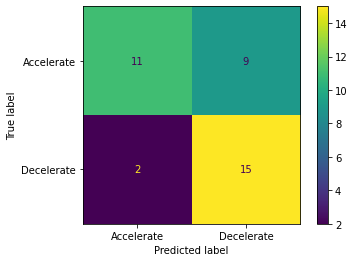

In [116]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plot_confusion_matrix(model_xgb,
                      X_val, 
                      y_val,
                      display_labels=['Accelerate', 'Decelerate'],
                      values_format='.0f')

In [117]:
print(classification_report(y_val,model_xgb.predict(X_val), target_names=['Accelerate','Decelerate']))

              precision    recall  f1-score   support

  Accelerate       0.85      0.55      0.67        20
  Decelerate       0.62      0.88      0.73        17

    accuracy                           0.70        37
   macro avg       0.74      0.72      0.70        37
weighted avg       0.74      0.70      0.70        37



Feature Importances

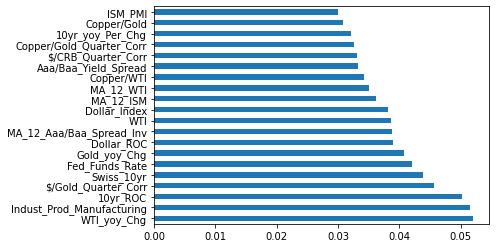

In [118]:
feature_imp = model_xgb.named_steps['xgbclassifier'] .feature_importances_
features = X_train.columns

pd.Series(feature_imp, features).sort_values(ascending=False).head(20).plot(kind='barh');

In [119]:
model_xgb.named_steps['xgbclassifier'].feature_importances_

array([0.03007188, 0.        , 0.02854055, 0.05018336, 0.03204025,
       0.04391352, 0.02373272, 0.03820144, 0.03898609, 0.05148051,
       0.03861998, 0.02780869, 0.05203033, 0.03324469, 0.        ,
       0.        , 0.01308928, 0.02078361, 0.04071309, 0.0307615 ,
       0.01570503, 0.02374724, 0.04200861, 0.03421365, 0.01713571,
       0.02729149, 0.03264147, 0.02435207, 0.04557562, 0.03303611,
       0.        , 0.        , 0.03626066, 0.03509579, 0.        ,
       0.03873508], dtype=float32)

In [120]:
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot

feature = ['Copper/Gold', 'WTI']

isolated = pdp_isolate(
    model=model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=feature
)

pdp_plot(isolated, feature_name=feature);

TypeError: ignored

In [ ]:
features = ['Copper/Gold Ratio', '10yr Rate']

interaction = pdp_interact(
    model=model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

#PDP Plots

In [ ]:
# View Feature
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_interact

In [ ]:
feature_imp = model.named_steps['xgbregressor'].feature_importances_
features = X_train.columns

pd.Series(feature_imp, features).sort_values(ascending=False).head(5).plot(kind='barh');

In [ ]:
features = ['Copper', 'DXY']

interaction = pdp_interact(
    model=model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

In [ ]:
plt.plot(df.index, df['Copper/Gold Ratio'])
plt.title('Copper/Gold Ratio')
plt.show()

plt.plot(df.index, df['10yr Rate'])
plt.title('10 year Rate')
plt.show()

plt.plot(df.index, df['Copper/WTI Ratio'])
plt.show()